Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

Dataset Preparation:
Clean and preprocess dataset,
Split into training/validation/test datasets

In [13]:
def load_and_preprocess_data(filepath='creditcard.csv'):
    try:
        df = pd.read_csv(filepath)
        print(f"Dataset loaded successfully. Shape: {df.shape}")
        print("First 5 rows:")
        display(df.head())

        print("\nMissing values per column:")
        print(df.isnull().sum().sort_values(ascending=False))
        if df.isnull().sum().any():
            print("Missing Values present")

        X = df.drop('Class', axis=1)
        y = df['Class']

        scaler = StandardScaler()
        X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

        print("\nTime and Amount features scaled.")
        print(f"Class distribution: Original Dataset\n{y.value_counts()}")
        print(f"Fraudulent transactions: {y.sum()} ({y.sum()/len(y)*100:.4f}%)")
        return X, y, scaler

    except FileNotFoundError:
        print(f"Error: File not found")
        exit()
    except Exception as e:
        print(f"An error occurred during data loading or preprocessing: {e}")
        exit()

In [3]:
def split_data(X, y, test_size=0.15, val_size=0.15, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(test_size + val_size), stratify=y, random_state=random_state)

    relative_test_size = test_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=relative_test_size, stratify=y_temp, random_state=random_state)

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    print(f"\nClass distribution in Training set:\n{y_train.value_counts()}")
    print(f"Class distribution in Validation set:\n{y_val.value_counts()}")
    print(f"Class distribution in Test set:\n{y_test.value_counts()}")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(8, latent_dim)
        self.logvar_layer = nn.Linear(8, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [15]:
def augment_data_with_vae(X_train, y_train, scaler, num_synthetic_samples=1000):
    fraud_data_train = X_train[y_train == 1]
    vae_features = [col for col in fraud_data_train.columns if col.startswith('V') or col == 'Amount']
    fraud_data_for_vae = fraud_data_train[vae_features]

    X_tensor = torch.tensor(fraud_data_for_vae.values, dtype=torch.float32)
    dataset = data.TensorDataset(X_tensor)
    dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True)

    input_dim = fraud_data_for_vae.shape[1]
    latent_dim = 2

    vae = VAE(input_dim, latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    epochs = 100
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x_batch = batch[0]
            optimizer.zero_grad()
            recon, mu, logvar = vae(x_batch)
            loss = vae_loss(recon, x_batch, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader.dataset)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_synthetic_samples, latent_dim)
        synthetic_data_scaled_vae_features = vae.decoder(z).numpy()

    synthetic_df_vae_features = pd.DataFrame(synthetic_data_scaled_vae_features, columns=vae_features)
    original_columns_order = X_train.columns.tolist()

    dummy_full_scaled_data = np.zeros((num_synthetic_samples, len(original_columns_order)))
    synthetic_full_scaled_df = pd.DataFrame(dummy_full_scaled_data, columns=original_columns_order)

    for col in vae_features:
        synthetic_full_scaled_df[col] = synthetic_df_vae_features[col]

    if 'Time' in synthetic_full_scaled_df.columns and 'Amount' in synthetic_full_scaled_df.columns:
        synthetic_full_scaled_df[['Time', 'Amount']] = scaler.inverse_transform(synthetic_full_scaled_df[['Time', 'Amount']])
    elif 'Time' in synthetic_full_scaled_df.columns:
        synthetic_full_scaled_df['Time'] = scaler.inverse_transform(synthetic_full_scaled_df[['Time']])[:, 0]
    elif 'Amount' in synthetic_full_scaled_df.columns:
        synthetic_full_scaled_df['Amount'] = scaler.inverse_transform(synthetic_full_scaled_df[['Amount']])[:, 0]
    else:
        print("Warning: Neither 'Time' nor 'Amount' columns found for inverse scaling.")


    synthetic_df_original_scale = synthetic_full_scaled_df.copy()

    synthetic_df_original_scale['Class'] = 1

    X_train_augmented = pd.concat([X_train, synthetic_df_original_scale.drop('Class', axis=1)], ignore_index=True)
    y_train_augmented = pd.concat([y_train, synthetic_df_original_scale['Class']], ignore_index=True)

    print(f"Generated {num_synthetic_samples} synthetic fraud samples.")
    print(f"Augmented training data shape: {X_train_augmented.shape}")
    print(f"Class distribution in Augmented Training set:\n{y_train_augmented.value_counts()}")
    print("Class distribution should now be more balanced.")

    return X_train_augmented, y_train_augmented

In [9]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_type="Original"):

    model.fit(X_train, y_train)
    print(f"{model_name} training complete.")

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\nClassification Report for {model_name} ({dataset_type}):")
    print(classification_report(y_test, y_pred, target_names=['Non-Fraud (0)', 'Fraud (1)']))

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {model_name} ({dataset_type}):")
    print(conf_matrix)

    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\nROC-AUC Score for {model_name} ({dataset_type}): {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
                yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
    plt.title(f'Confusion Matrix - {model_name} ({dataset_type})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(7, 6))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name} ({dataset_type})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

Dataset loaded successfully. Shape: (284807, 31)
First 5 rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Time and Amount features scaled.
Class distribution: Original Dataset
Class
0    284315
1       492
Name: count, dtype: int64
Fraudulent transactions: 492 (0.1727%)
X_train shape: (199364, 30), y_train shape: (199364,)
X_val shape: (42721, 30), y_val shape: (42721,)
X_test shape: (42722, 30), y_test shape: (42722,)

Class distribution in Training set:
Class
0    199020
1       344
Name: count, dtype: int64
Class distribution in Validation set:
Class
0    42647
1       74
Name: count, dtype: int64
Class distribution in Test set:
Class
0    42648
1       74
Name: count, dtype: int6

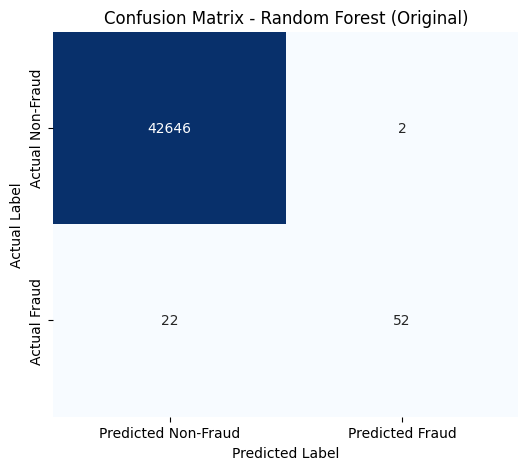

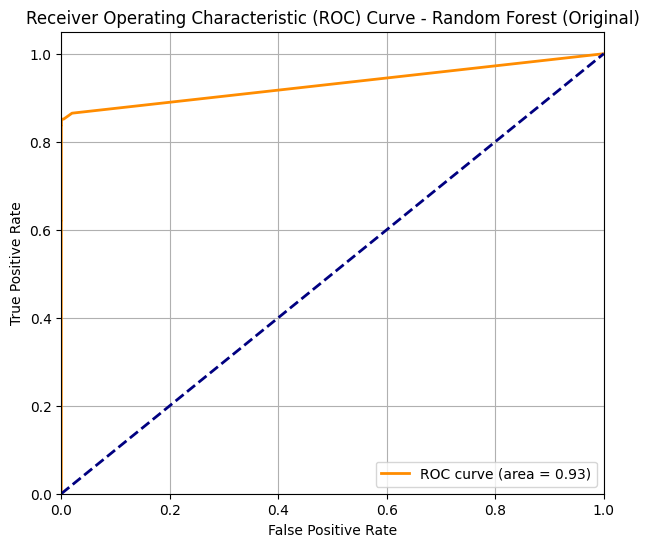

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:44:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete.

Classification Report for XGBoost (Original):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     42648
    Fraud (1)       0.81      0.80      0.80        74

     accuracy                           1.00     42722
    macro avg       0.90      0.90      0.90     42722
 weighted avg       1.00      1.00      1.00     42722


Confusion Matrix for XGBoost (Original):
[[42634    14]
 [   15    59]]

ROC-AUC Score for XGBoost (Original): 0.9524


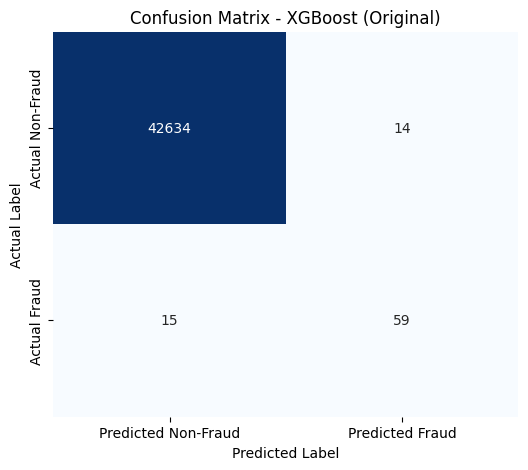

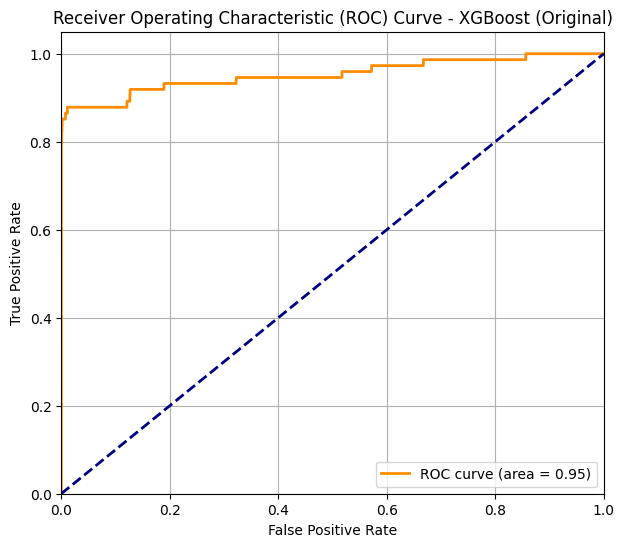

Logistic Regression training complete.

Classification Report for Logistic Regression (Original):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.98      0.99     42648
    Fraud (1)       0.07      0.88      0.12        74

     accuracy                           0.98     42722
    macro avg       0.53      0.93      0.56     42722
 weighted avg       1.00      0.98      0.99     42722


Confusion Matrix for Logistic Regression (Original):
[[41742   906]
 [    9    65]]

ROC-AUC Score for Logistic Regression (Original): 0.9677


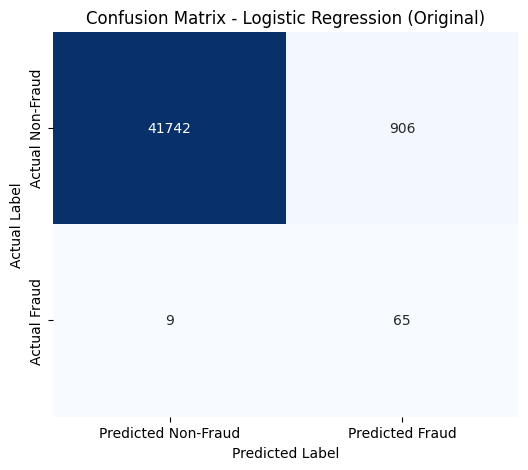

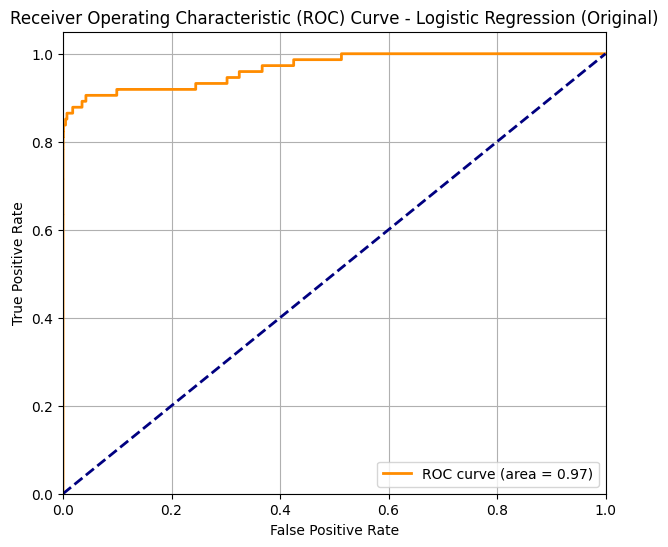


                 EVALUATING MODELS ON AUGMENTED DATASET
Random Forest training complete.

Classification Report for Random Forest (Augmented):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     42648
    Fraud (1)       0.96      0.72      0.82        74

     accuracy                           1.00     42722
    macro avg       0.98      0.86      0.91     42722
 weighted avg       1.00      1.00      1.00     42722


Confusion Matrix for Random Forest (Augmented):
[[42646     2]
 [   21    53]]

ROC-AUC Score for Random Forest (Augmented): 0.9308


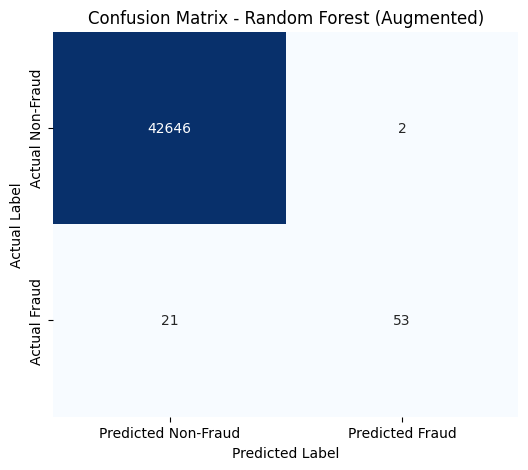

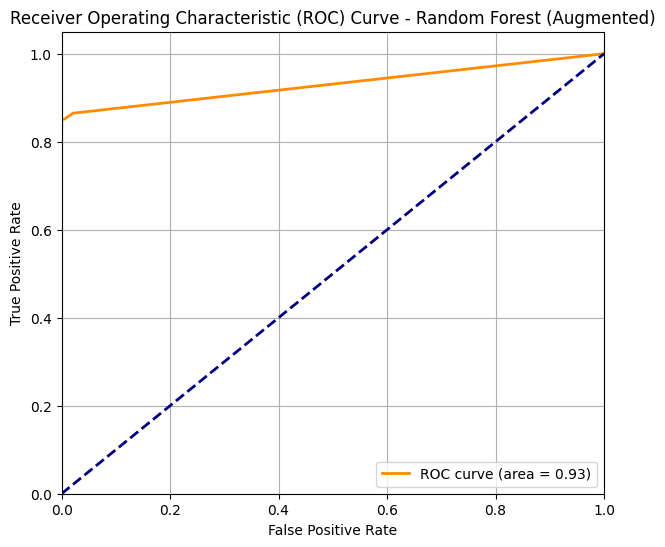

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:48:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete.

Classification Report for XGBoost (Augmented):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     42648
    Fraud (1)       0.79      0.81      0.80        74

     accuracy                           1.00     42722
    macro avg       0.89      0.91      0.90     42722
 weighted avg       1.00      1.00      1.00     42722


Confusion Matrix for XGBoost (Augmented):
[[42632    16]
 [   14    60]]

ROC-AUC Score for XGBoost (Augmented): 0.9506


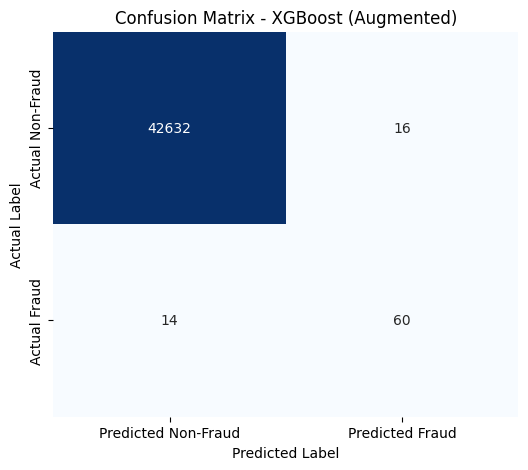

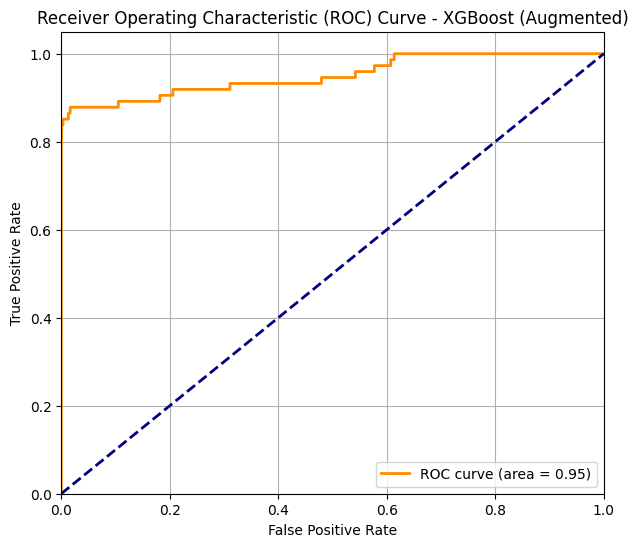

Logistic Regression training complete.

Classification Report for Logistic Regression (Augmented):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.99      1.00     42648
    Fraud (1)       0.21      0.84      0.34        74

     accuracy                           0.99     42722
    macro avg       0.61      0.92      0.67     42722
 weighted avg       1.00      0.99      1.00     42722


Confusion Matrix for Logistic Regression (Augmented):
[[42418   230]
 [   12    62]]

ROC-AUC Score for Logistic Regression (Augmented): 0.9644


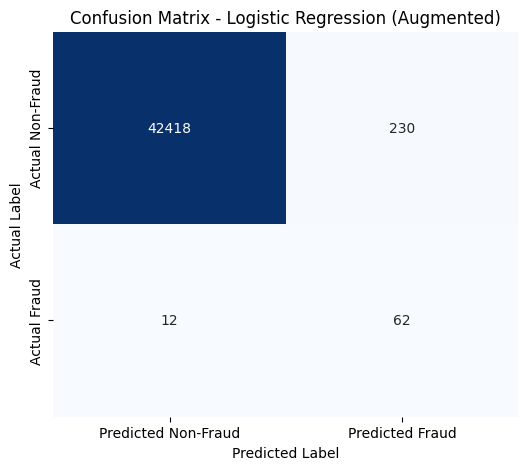

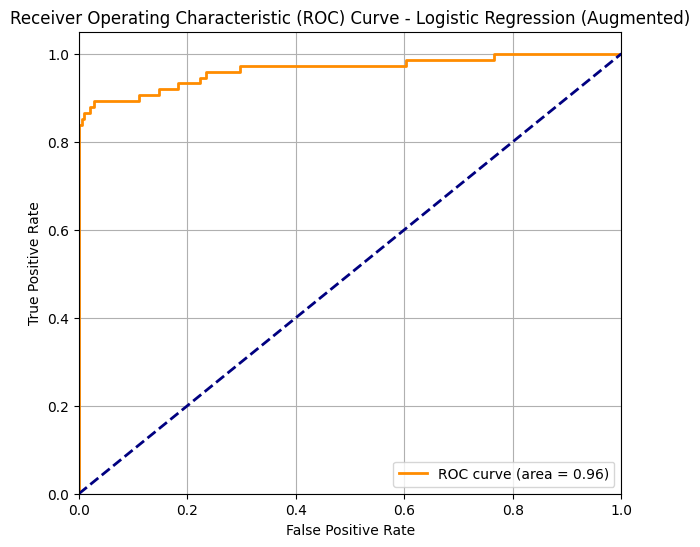


--- Analysis Complete ---
Review the output for classification reports, confusion matrices, and ROC curves.
Pay close attention to Recall (fraud detection rate) and Precision (false positive rate).
Compare model performance on the 'Original' vs. 'Augmented' datasets.

                 EVALUATING MODELS ON ORIGINAL DATASET
Random Forest training complete.

Classification Report for Random Forest (Original):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     42648
    Fraud (1)       0.96      0.70      0.81        74

     accuracy                           1.00     42722
    macro avg       0.98      0.85      0.91     42722
 weighted avg       1.00      1.00      1.00     42722


Confusion Matrix for Random Forest (Original):
[[42646     2]
 [   22    52]]

ROC-AUC Score for Random Forest (Original): 0.9309


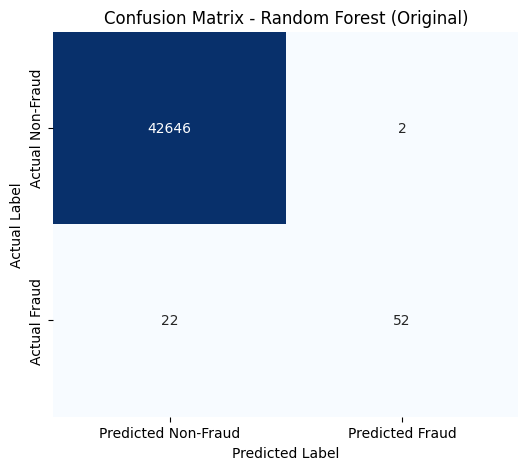

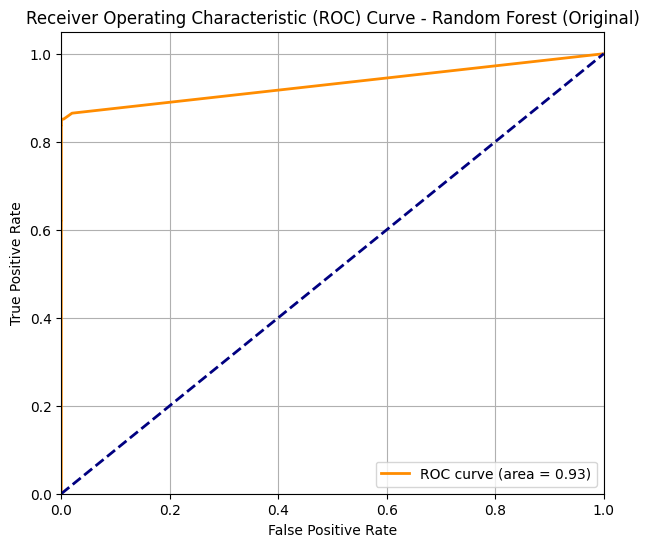

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:50:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete.

Classification Report for XGBoost (Original):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     42648
    Fraud (1)       0.81      0.80      0.80        74

     accuracy                           1.00     42722
    macro avg       0.90      0.90      0.90     42722
 weighted avg       1.00      1.00      1.00     42722


Confusion Matrix for XGBoost (Original):
[[42634    14]
 [   15    59]]

ROC-AUC Score for XGBoost (Original): 0.9524


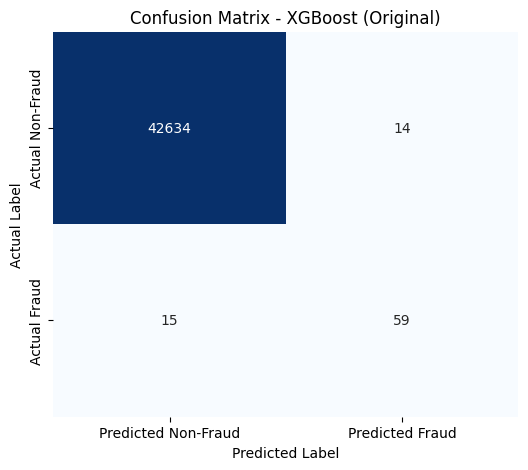

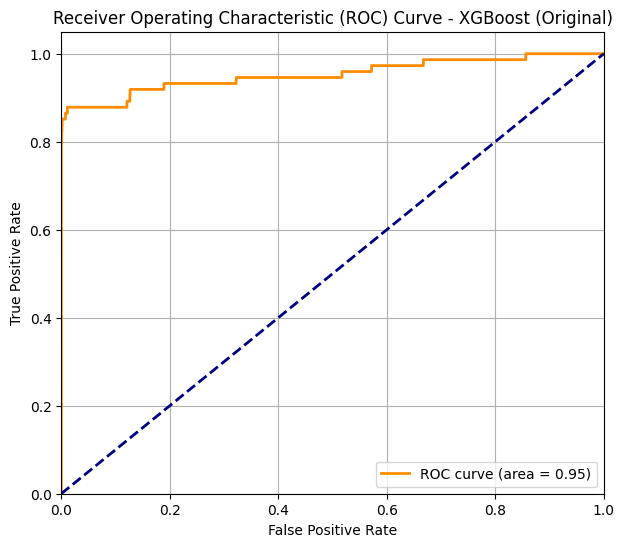

Logistic Regression training complete.

Classification Report for Logistic Regression (Original):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.98      0.99     42648
    Fraud (1)       0.07      0.88      0.12        74

     accuracy                           0.98     42722
    macro avg       0.53      0.93      0.56     42722
 weighted avg       1.00      0.98      0.99     42722


Confusion Matrix for Logistic Regression (Original):
[[41742   906]
 [    9    65]]

ROC-AUC Score for Logistic Regression (Original): 0.9677


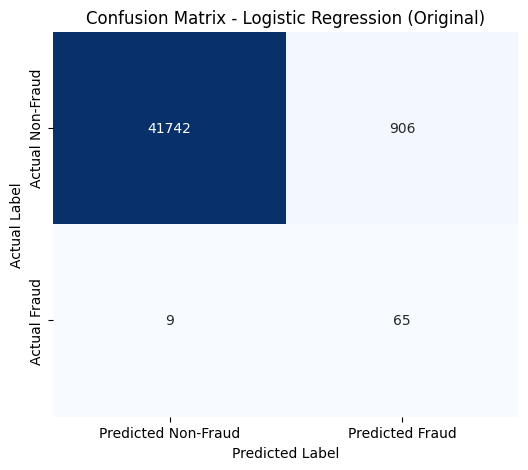

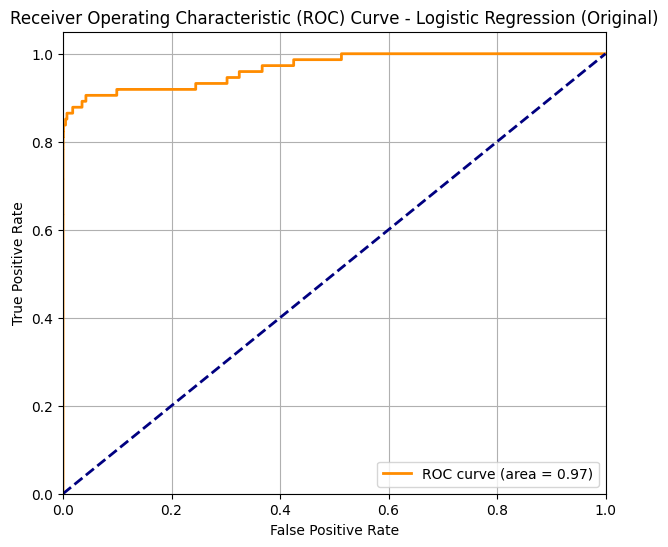


                 EVALUATING MODELS ON AUGMENTED DATASET
Random Forest training complete.

Classification Report for Random Forest (Augmented):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     42648
    Fraud (1)       0.96      0.72      0.82        74

     accuracy                           1.00     42722
    macro avg       0.98      0.86      0.91     42722
 weighted avg       1.00      1.00      1.00     42722


Confusion Matrix for Random Forest (Augmented):
[[42646     2]
 [   21    53]]

ROC-AUC Score for Random Forest (Augmented): 0.9308


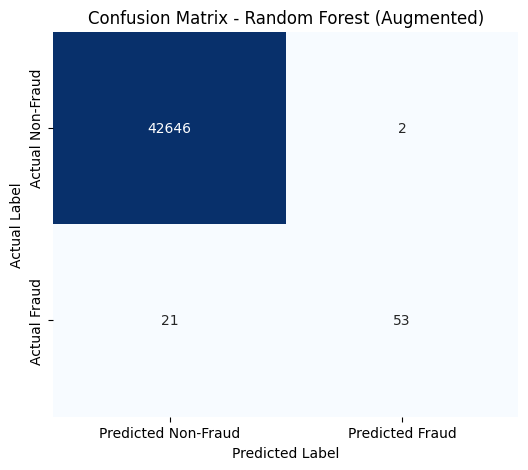

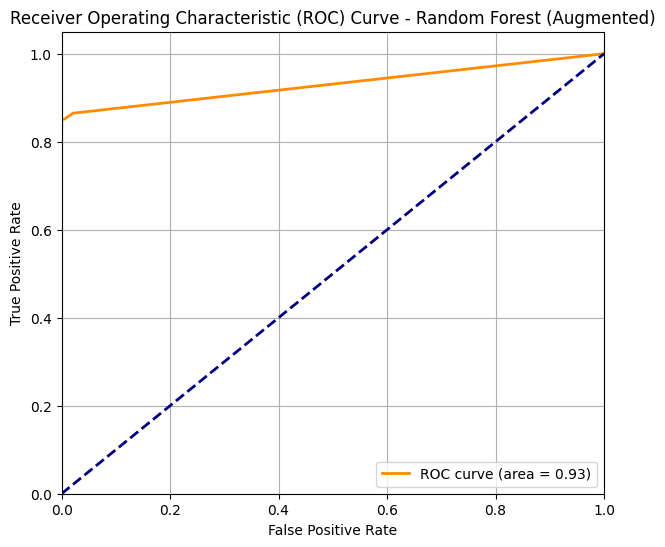

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:53:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete.

Classification Report for XGBoost (Augmented):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     42648
    Fraud (1)       0.79      0.81      0.80        74

     accuracy                           1.00     42722
    macro avg       0.89      0.91      0.90     42722
 weighted avg       1.00      1.00      1.00     42722


Confusion Matrix for XGBoost (Augmented):
[[42632    16]
 [   14    60]]

ROC-AUC Score for XGBoost (Augmented): 0.9506


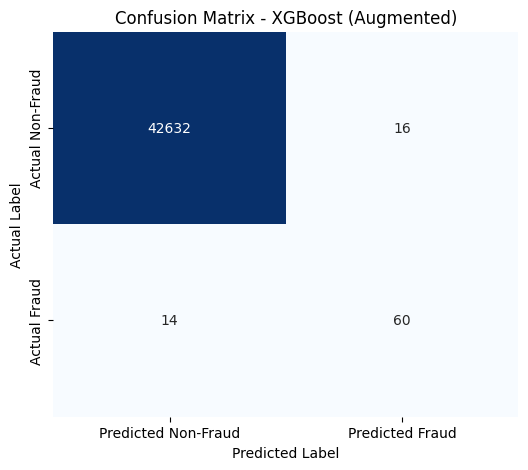

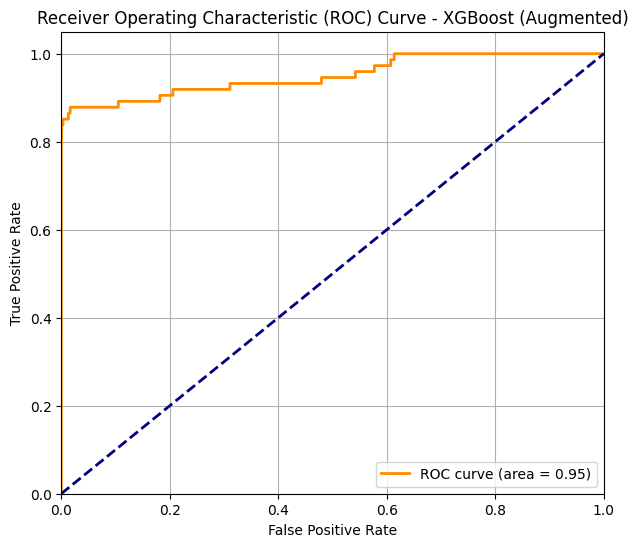

Logistic Regression training complete.

Classification Report for Logistic Regression (Augmented):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.99      1.00     42648
    Fraud (1)       0.21      0.84      0.34        74

     accuracy                           0.99     42722
    macro avg       0.61      0.92      0.67     42722
 weighted avg       1.00      0.99      1.00     42722


Confusion Matrix for Logistic Regression (Augmented):
[[42418   230]
 [   12    62]]

ROC-AUC Score for Logistic Regression (Augmented): 0.9644


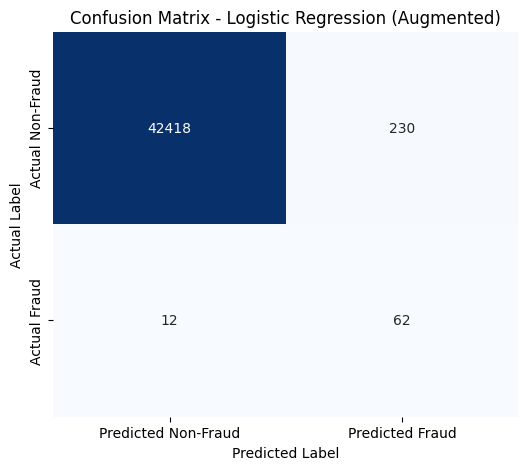

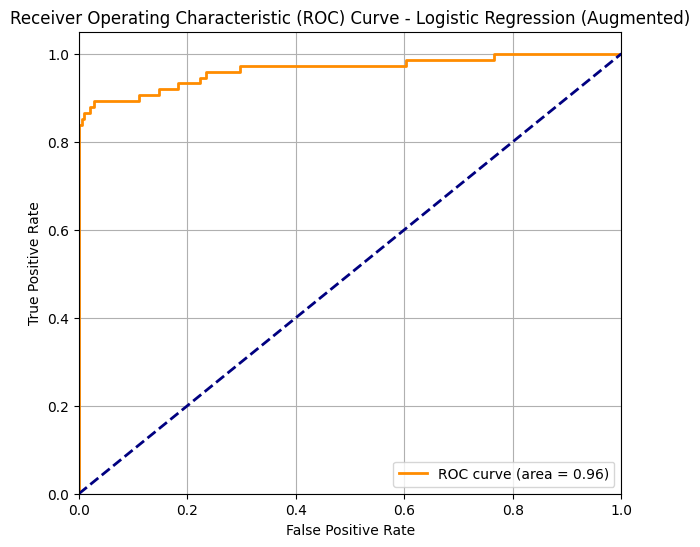


--- Analysis Complete ---
Review the output for classification reports, confusion matrices, and ROC curves.
Pay close attention to Recall (fraud detection rate) and Precision (false positive rate).
Compare model performance on the 'Original' vs. 'Augmented' datasets.


In [19]:
if __name__ == "__main__":
    DATA_FILEPATH = 'creditcard.csv'

    X_scaled_full, y_original, data_scaler = load_and_preprocess_data(DATA_FILEPATH)
    X_train_orig, X_val_orig, X_test_orig, y_train_orig, y_val_orig, y_test_orig = split_data(X_scaled_full, y_original)

    X_train_augmented, y_train_augmented = augment_data_with_vae(X_train_orig, y_train_orig, data_scaler, num_synthetic_samples=1000)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

    scale_pos_weight_val_orig = (y_train_orig == 0).sum() / (y_train_orig == 1).sum()
    xgb_model_orig = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, n_estimators=100, learning_rate=0.1, random_state=42, scale_pos_weight=scale_pos_weight_val_orig)

    lr_model_orig = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)

    scale_pos_weight_val_aug = (y_train_augmented == 0).sum() / (y_train_augmented == 1).sum()
    xgb_model_aug = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, n_estimators=100, learning_rate=0.1, random_state=42, scale_pos_weight=scale_pos_weight_val_aug)

    rf_model_aug = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    lr_model_aug = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)

    print("EVALUATING MODELS ON ORIGINAL DATASET")
    train_and_evaluate_model(rf_model, X_train_orig, y_train_orig, X_test_orig, y_test_orig, "Random Forest", "Original")
    train_and_evaluate_model(xgb_model_orig, X_train_orig, y_train_orig, X_test_orig, y_test_orig, "XGBoost", "Original")
    train_and_evaluate_model(lr_model_orig, X_train_orig, y_train_orig, X_test_orig, y_test_orig, "Logistic Regression", "Original")

    print("EVALUATING MODELS ON AUGMENTED DATASET")
    train_and_evaluate_model(rf_model_aug, X_train_augmented, y_train_augmented, X_test_orig, y_test_orig, "Random Forest", "Augmented")
    train_and_evaluate_model(xgb_model_aug, X_train_augmented, y_train_augmented, X_test_orig, y_test_orig, "XGBoost", "Augmented")
    train_and_evaluate_model(lr_model_aug, X_train_augmented, y_train_augmented, X_test_orig, y_test_orig, "Logistic Regression", "Augmented")

    print("\n--- Analysis Complete ---")
    print("Review the output for classification reports, confusion matrices, and ROC curves.")
    print("Pay close attention to Recall (fraud detection rate) and Precision (false positive rate).")
    print("Compare model performance on the 'Original' vs. 'Augmented' datasets.")
    print("EVALUATING MODELS ON ORIGINAL DATASET")
    train_and_evaluate_model(rf_model, X_train_orig, y_train_orig, X_test_orig, y_test_orig, "Random Forest", "Original")
    train_and_evaluate_model(xgb_model_orig, X_train_orig, y_train_orig, X_test_orig, y_test_orig, "XGBoost", "Original")
    train_and_evaluate_model(lr_model_orig, X_train_orig, y_train_orig, X_test_orig, y_test_orig, "Logistic Regression", "Original")

    print("EVALUATING MODELS ON AUGMENTED DATASET")
    train_and_evaluate_model(rf_model_aug, X_train_augmented, y_train_augmented, X_test_orig, y_test_orig, "Random Forest", "Augmented")
    train_and_evaluate_model(xgb_model_aug, X_train_augmented, y_train_augmented, X_test_orig, y_test_orig, "XGBoost", "Augmented")
    train_and_evaluate_model(lr_model_aug, X_train_augmented, y_train_augmented, X_test_orig, y_test_orig, "Logistic Regression", "Augmented")

    print("\n--- Analysis Complete ---")
    print("Review the output for classification reports, confusion matrices, and ROC curves.")
    print("Pay close attention to Recall (fraud detection rate) and Precision (false positive rate).")
    print("Compare model performance on the 'Original' vs. 'Augmented' datasets.")